In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hulearn.datasets import load_titanic

df = load_titanic(as_frame=True)
df.head()

,survived,pclass,name,sex,age,fare,sibsp,parch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,0,0


In [3]:
X, y = df.drop(columns=['survived']), df['survived']

How might we declare a rule in python? Why not a function!

In [4]:
import numpy as np
from hulearn.classification import FunctionClassifier

def fare_based(dataf, threshold=10):
    """
    The assumption is that folks who paid more are wealthier and are more
    likely to have recieved access to lifeboats.
    """
    return np.array(dataf['fare'] > threshold).astype(int)

One core feature of this package is to turn functions (with custom logic) into scikit-learn classifiers. 

In [5]:
mod = FunctionClassifier(fare_based, threshold=10)

These classifiers can be "grid-searched" even!

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

# Note the threshold keyword argument in this function.
def fare_based(dataf, threshold=10):
    return np.array(dataf['fare'] > threshold).astype(int)

# Pay attention here, we set the threshold argument in here.
mod = FunctionClassifier(fare_based, threshold=10)

# The GridSearch object can now "grid-search" over this argument.
# We also add a bunch of metrics to our approach so we can measure.
grid = GridSearchCV(mod,
                    cv=2,
                    param_grid={'threshold': np.linspace(0, 100, 30)},
                    scoring={'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                    refit='accuracy')
grid.fit(X, y);

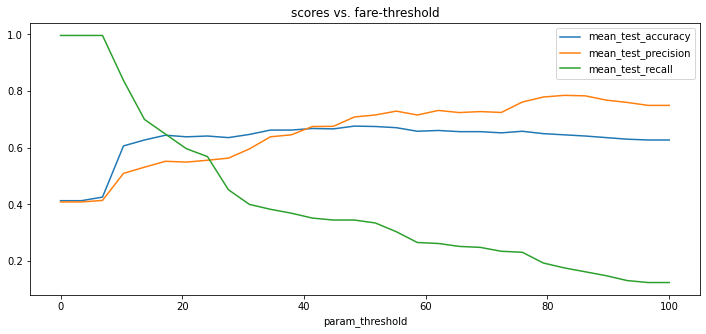

In [7]:
import pandas as pd

score_df = (pd.DataFrame(grid.cv_results_)
  .set_index('param_threshold')
  [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']])

score_df.plot(figsize=(12, 5), title="scores vs. fare-threshold");

This method is very useful! We can also use it to make systems like; 

![](https://koaning.io/posts/high-on-probability-low-on-certainty/fallback.png)

Here's the pseudo-code. 

```python
import numpy as np
from hulearn.outlier import InteractiveOutlierDetector
from hulearn.classification import FunctionClassifier, InteractiveClassifier

outlier    = WhatEverOutlier().fit(X, y)
classifier = WhatEverClassifier().fit(X, y)

def make_decision(dataf, threshold=0.8):
    # First we create a resulting array with all the predictions
    res = classifier.predict(dataf)

    # If we detect doubt, "classify" it as a fallback instead.
    proba = classifier.predict_proba(dataf)
    res = np.where(proba.max(axis=1) < threshold, "doubt_fallback", res)

    # If we detect an ourier, we'll fallback too.
    res = np.where(outlier.predict(dataf) == -1, "outlier_fallback", res)

    # This `res` array contains the output of the drawn diagram.
    return res

fallback_model = FunctionClassifier(make_decision, threshold=0.8)
```

This library offers a whole family of `Function`- tools. 

- `FunctionClassifier`
- `FunctionRegressor`
- `FunctionOutlierDetector`


## Better Rules 

But maybe ... we can rethink rule bases systems here. Maybe it's a user-interface problem.

In [27]:
from sklego.datasets import load_penguins
from hulearn.experimental.interactive import InteractiveCharts

df = load_penguins(as_frame=True).dropna()
clf = InteractiveCharts(df, labels="species")

Loading BokehJS ...

In [29]:
clf.add_chart(x="bill_length_mm", y="bill_depth_mm", legend=False)

In [12]:
clf.add_chart(x="flipper_length_mm", y="body_mass_g")

In [25]:
from hulearn.classification import InteractiveClassifier

model = InteractiveClassifier(json_desc=clf.data())

In [26]:
X, y = df.drop(columns=['species']), df['species']

preds = model.fit(X, y).predict_proba(X)

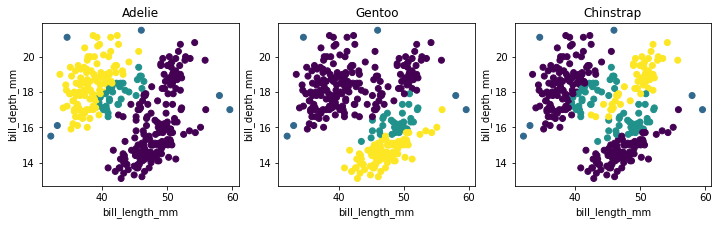

In [27]:
import matplotlib.pylab as plt

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(131 + i)
    plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds[:, i])
    plt.xlabel('bill_length_mm')
    plt.ylabel('bill_depth_mm')
    plt.title(model.classes_[i])

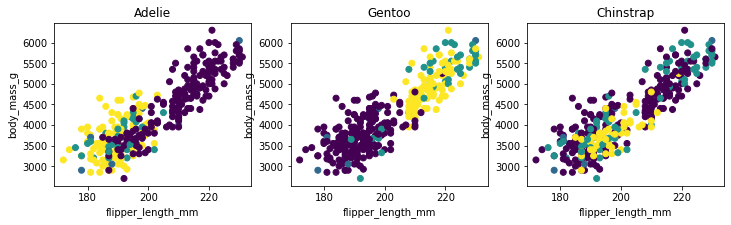

In [28]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(131 + i)
    plt.scatter(X['flipper_length_mm'], X['body_mass_g'], c=preds[:, i])
    plt.xlabel('flipper_length_mm')
    plt.ylabel('body_mass_g')
    plt.title(model.classes_[i])

In this family of "drawing" models we've also got some options; 

- `InteractiveClassifier`
- `InteractiveOutlierDetector`
- `InteractivePreprocessor`

In [29]:
from hulearn.experimental.interactive import InteractiveCharts

# Note that the `labels` arugment here is a list, not a string! This
# tells the tool that we want to be able to add custom groups that are
# not defined by a column in the dataframe.
charts = InteractiveCharts(df, labels=['group_one', 'group_two'])

Loading BokehJS ...

In [ ]:
%pip install human-learn

In [31]:
charts.add_chart(x="flipper_length_mm", y="body_mass_g")

In [32]:
from hulearn.preprocessing import InteractivePreprocessor
tfm = InteractivePreprocessor(json_desc=charts.data())

In [33]:
# The flow for pandas
df.pipe(tfm.pandas_pipe).head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,group_one,group_two
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,1,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,1,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,1,0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,1,0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,1,0


In [20]:
# The flow for scikit-learn
tfm.fit(df).transform(df)[:5]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])